# Predicción de Series Temporales NN - Embedding

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

**Cargamos el Dataset**

In [ ]:
df = pd.read_csv('time_series_ab_eximben.csv',  parse_dates=[0], header=None,index_col=0, names=['fecha','unidades'])
df.head()

,unidades
fecha,
2014-01-02,23
2014-01-03,26
2014-01-04,59
2014-01-06,66
2014-01-07,37


In [ ]:
# Nueva columna de día de la semana
df['weekday']=[x.weekday() for x in df.index]
# Nueva clumna de mes
df['month']=[x.month for x in df.index]
# Nueva columna de año
df['year']=[x.year for x in df.index]

df.head()

,unidades,weekday,month,year
fecha,,,,
2014-01-02,23,3,1,2014
2014-01-03,26,4,1,2014
2014-01-04,59,5,1,2014
2014-01-06,66,0,1,2014
2014-01-07,37,1,1,2014


In [ ]:
df.describe()

,unidades,weekday,month,year
count,1607.000000,1607.000000,1607.000000,1607.000000
mean,27.103920,2.645924,6.155569,2016.308027
std,19.197078,1.799324,3.459525,1.609925
min,1.000000,0.000000,1.000000,2014.000000
25%,14.000000,1.000000,3.000000,2015.000000
50%,23.000000,3.000000,6.000000,2016.000000
75%,35.000000,4.000000,9.000000,2018.000000
max,150.000000,6.000000,12.000000,2019.000000


# Preprocesado de los datos

In [ ]:
PASOS=7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# Se asigna columna unidades a value
values = df['unidades'].values


# Se define que sean valores decimales
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
print(scaler)

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df['weekday']
reframed['month']=df['month']
reframed['year']=df['year']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df['weekday'][i+8]
    reframed['month'].loc[contador]=df['month'][i+8]
    reframed['year'].loc[contador]=df['year'][i+8]
    contador=contador+1
reframed.tail()

MinMaxScaler(copy=True, feature_range=(-1, 1))


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month,year
1595,-0.704698,-0.677852,-0.906040,-0.919463,-0.892617,-0.852349,-0.838926,-0.530201,0.0,6.0,2019.0
1596,-0.677852,-0.906040,-0.919463,-0.892617,-0.852349,-0.838926,-0.530201,-0.758389,1.0,6.0,2019.0
1597,-0.906040,-0.919463,-0.892617,-0.852349,-0.838926,-0.530201,-0.758389,-0.919463,2.0,6.0,2019.0
1598,-0.919463,-0.892617,-0.852349,-0.838926,-0.530201,-0.758389,-0.919463,-0.865772,3.0,6.0,2019.0
1599,-0.892617,-0.852349,-0.838926,-0.530201,-0.758389,-0.919463,-0.865772,-0.865772,NaN,NaN,NaN


In [ ]:
reordenado=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reordenado.dropna(inplace=True)
reordenado

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,5.0,1.0,-0.704698,-0.664430,-0.221477,-0.127517,-0.516779,-0.489933,-0.691275,-0.624161
1,0.0,1.0,-0.664430,-0.221477,-0.127517,-0.516779,-0.489933,-0.691275,-0.624161,-0.463087
2,1.0,1.0,-0.221477,-0.127517,-0.516779,-0.489933,-0.691275,-0.624161,-0.463087,-0.610738
3,2.0,1.0,-0.127517,-0.516779,-0.489933,-0.691275,-0.624161,-0.463087,-0.610738,-0.476510
4,3.0,1.0,-0.516779,-0.489933,-0.691275,-0.624161,-0.463087,-0.610738,-0.476510,-0.570470
5,4.0,1.0,-0.489933,-0.691275,-0.624161,-0.463087,-0.610738,-0.476510,-0.570470,-0.583893
6,5.0,1.0,-0.691275,-0.624161,-0.463087,-0.610738,-0.476510,-0.570470,-0.583893,-0.436242
7,0.0,1.0,-0.624161,-0.463087,-0.610738,-0.476510,-0.570470,-0.583893,-0.436242,-0.100671
8,1.0,1.0,-0.463087,-0.610738,-0.476510,-0.570470,-0.583893,-0.436242,-0.100671,-0.261745
9,2.0,1.0,-0.610738,-0.476510,-0.570470,-0.583893,-0.436242,-0.100671,-0.261745,-0.691275


# Dividimos en set de Entrenamiento y Validación

In [ ]:
training_data = reordenado.drop('var1(t)',axis=1)#.values
target_data=reordenado['var1(t)']
print(training_data.head())
valid_data = training_data[1599-30:1599]
valid_target=target_data[1599-30:1599]

training_data = training_data[0:1599]
target_data=target_data[0:1599]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)
#training_data.head()

   weekday  month  var1(t-7)  ...  var1(t-3)  var1(t-2)  var1(t-1)
0      5.0    1.0  -0.704698  ...  -0.516779  -0.489933  -0.691275
1      0.0    1.0  -0.664430  ...  -0.489933  -0.691275  -0.624161
2      1.0    1.0  -0.221477  ...  -0.691275  -0.624161  -0.463087
3      2.0    1.0  -0.127517  ...  -0.624161  -0.463087  -0.610738
4      3.0    1.0  -0.516779  ...  -0.463087  -0.610738  -0.476510

[5 rows x 9 columns]
(1599, 9) (1599,) (30, 9) (30,)


# Creamos el modelo de Red Neuronal
**Utilizaremos una Red Feedfordward con Embeddings**

In [ ]:
def crear_modeloEmbeddings():
    emb_dias = 2 #tamanio profundidad de embeddings
    emb_meses = 4

    in_dias = Input(shape=[1], name = 'dias')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'meses')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

# Entrenamos nuestra máquina

In [ ]:
EPOCHS=40

model = crear_modeloEmbeddings()

continuas=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuas=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuas], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuas],valid_target))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dias (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
meses (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 1, 2)         16          dias[0][0]                       
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 1, 4)         52          meses[0][0]                      
__________________________________________________________________________________________________
concatenat

# Visualizamos Resultados

30


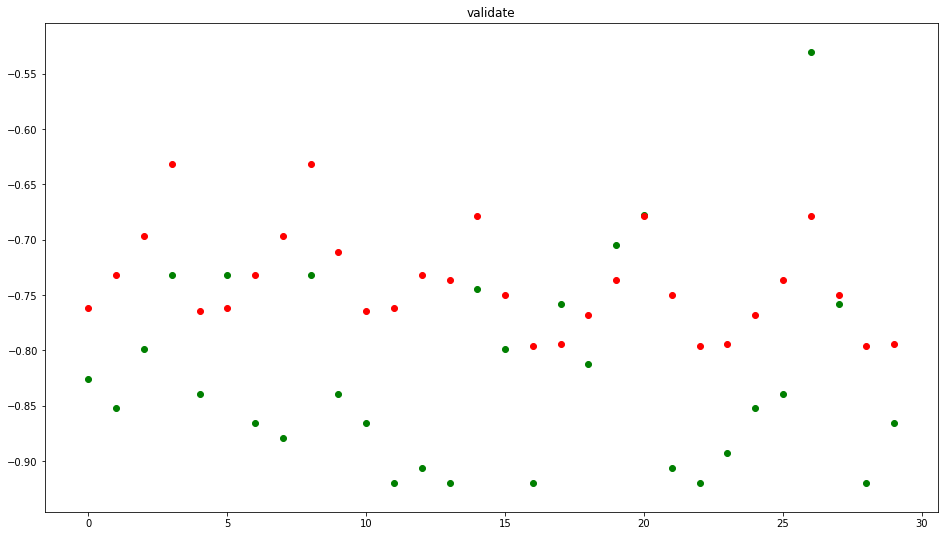

In [ ]:
results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuas])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

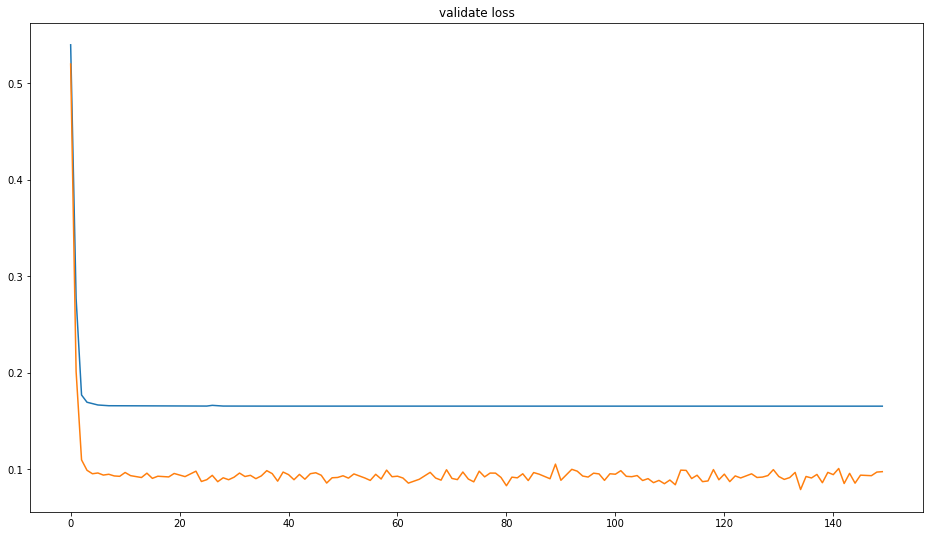

In [ ]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

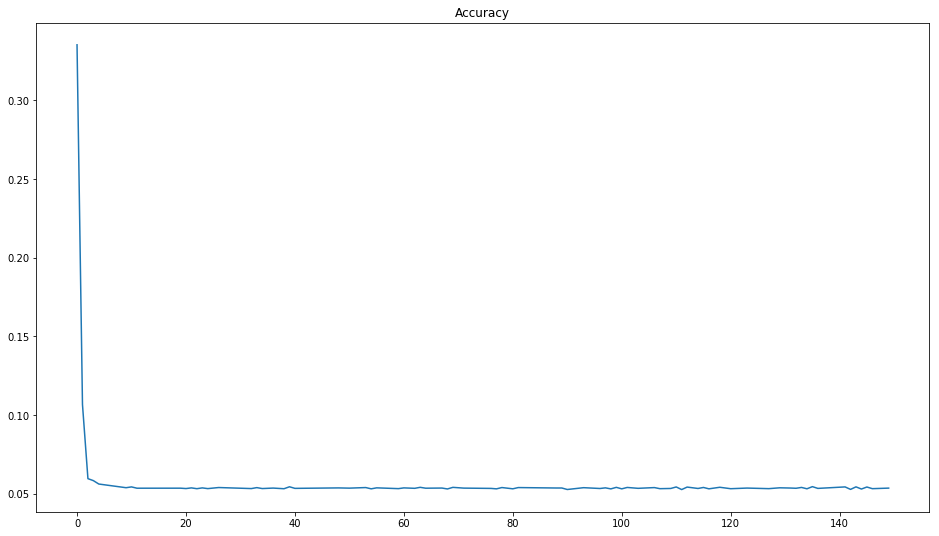

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [ ]:
compara = pd.DataFrame(np.array([valid_target, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(12)

,real,prediccion,diferencia
0,14.000003,18.786587,-4.786584
1,11.999998,21.001766,-9.001768
2,15.999998,23.606182,-7.606184
3,21.000000,28.423304,-7.423304
4,13.000000,18.576216,-5.576216
5,21.000000,18.786587,2.213413
6,11.000001,21.001766,-10.001765
7,9.999999,23.606182,-13.606183
8,21.000000,28.423304,-7.423304
9,13.000000,22.495584,-9.495584


In [ ]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,14.400000,20.428713,-6.028710
std,6.744602,3.444316,5.560637
min,7.000001,16.176149,-13.618217
25%,9.250000,18.373627,-9.176147
50%,13.000000,19.643723,-7.423304
75%,19.000000,22.122130,-3.929439
max,36.000000,28.423304,11.068460


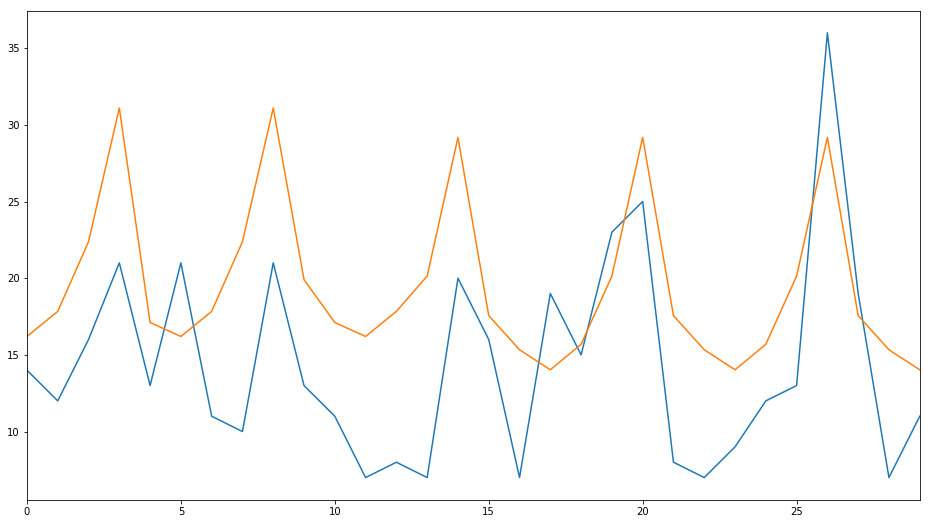

In [ ]:
compara2['real'].plot() #Azul
compara2['prediccion'].plot() #Naranjo

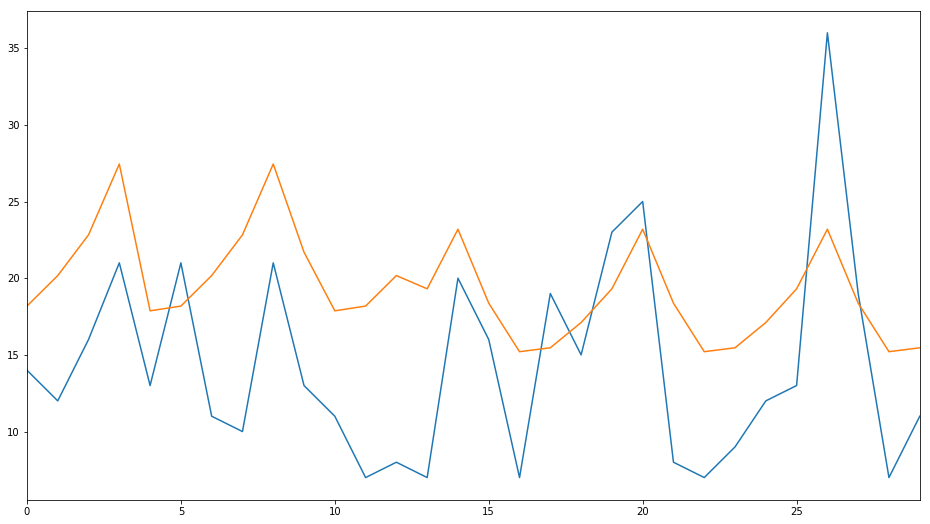

In [ ]:
compara2['real'].plot()
compara2['prediccion'].plot()